In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. Env

In [2]:
maze0 = [
    "###########",
    "#    #   9#",
    "#    #    #",
    "#    #    #",
    "#S   #    #",
    "#    #    #",
    "#    #    #",
    "#         #",
    "#         #",
    "###########",
]
print(len(maze0), len(maze0[0]))

10 11


In [3]:
Actions = [(0, 1), (-1, 0), (0, -1), (1, 0)]


class Env:
    """2d gridworld environment"""

    def __init__(self, maze, step_reward=0):
        self.maze = maze
        self.step_reward = step_reward
        self.state_visit = np.zeros((self.height(), self.width()))
        self.state_action_visit = np.zeros(
            (self.height(), self.width(), len(Actions)))
        self.reset()

    def reset(self):
        """initialize to begin with a new episode"""
        self.state = self.find_start_state()
        self.state_visit[self.state[0], self.state[1]] += 1
        return self.state, self.state_visit  # observation, info

    def step(self, action):
        """take an action and return tuple of state, reard, terminal, ..."""
        assert 0 <= action < 4
        neighbor = self.state + Actions[action]
        self.state_action_visit[self.state[0], self.state[1], action] += 1
        if not self.passable(neighbor):
            neighbor = self.state
        self.state = neighbor
        self.state_visit[self.state[0], self.state[1]] += 1
        if self.is_goal(self.state):
            return self.state, self.reward(neighbor), True, False, self.state_visit
        # obs., r, terminal,, info
        return self.state, self.step_reward, False, False, self.state_visit

    def height(self):
        return len(self.maze)

    def width(self):
        return len(self.maze[0])

    def find_start_state(self):
        """find a start position denoted by letter 'S' in maze"""
        for y in range(self.height()):
            if 'S' in self.maze[y]:
                return np.array([y, self.maze[y].index('S')])
        raise RuntimeError('find_start_state failed')

    def passable(self, yx):
        """return maze at yx is passable"""
        return self.maze[yx[0]][yx[1]] != '#'

    def is_goal(self, yx):
        """return maze at yx is a goal"""
        return self.maze[yx[0]][yx[1]].isdigit()

    def reward(self, yx):
        """return a reward on arriving state yx"""
        return int(self.maze[yx[0]][yx[1]]) if self.is_goal(yx) else 0

In [4]:
env = Env(maze0)
env.width(), env.height()

(11, 10)

# 2. Random Walk

In [5]:
def random_walk(step_limit):
    env = Env(maze0)
    obs, info = env.reset()
    for step in range(step_limit):
        action = random.randrange(len(Actions)) # 等確率
        obs, reward, terminal, interrupt, info = env.step(action)
    if terminal or interrupt:
        obs, info = env.reset()
    return env.state_visit

In [6]:
visits = random_walk(1000)
visits

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 19., 23., 28., 21.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 20., 23., 28., 31.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 35., 33., 42., 48.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 43., 27., 32., 34.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 41., 27., 21., 24.,  0.,  1.,  3.,  2.,  0.,  0.],
       [ 0., 27., 25., 23., 22.,  0., 11., 13.,  9.,  2.,  0.],
       [ 0., 22., 20., 21., 13.,  7., 14., 17., 14.,  2.,  0.],
       [ 0., 27., 19., 18., 11., 12., 17., 17., 12.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

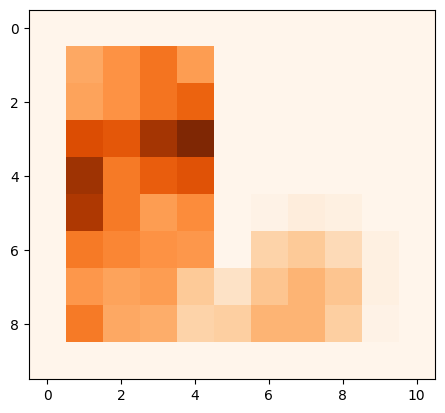

In [7]:
plt.imshow(visits, cmap='Oranges')

# 3. Q-learning with ϵ-greedy

Terminated in 267 episodes.


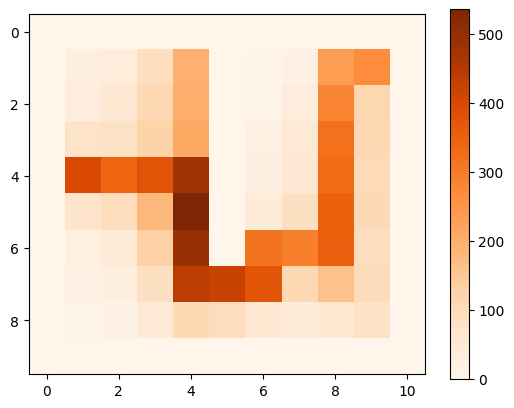

In [16]:
def sample_action(action_values, eps):
    p = random.random()
    if p < eps:
        return random.randrange(len(action_values))
    return action_values.argmax()

def make_q_table(env):
    return np.zeros((env.height(), env.width(), len(Actions)))

def Q_agent(step_limit, initial_eps=1.0, alpha=0.1, maze=maze0, r=1):
    env = Env(maze0)
    obs, info = env.reset()
    q_table = make_q_table(env)
    num_episodes = 0
    steps = 0
    for s in range(step_limit):
        eps = initial_eps * (step_limit - s) / step_limit
        # update q_table --- ここを自分で書いてみよう ---
        action = sample_action(q_table[obs[0]][obs[1]], eps)
        next_obs, reward, terminated, truncated, info = env.step(action)
        steps += 1
        # V(s_T)=0
        v_next= 0 if terminated or truncated else max(q_table[next_obs[0]][next_obs[1]]) 
        v = q_table[obs[0]][obs[1]][action]
        q_table[obs[0]][obs[1]][action] = v + alpha*(reward+r*v_next-v)
        obs = next_obs
        if terminated or truncated:
            obs, info = env.reset()
            num_episodes += 1
            # print(steps)
            steps = 0
    return env.state_visit, q_table, num_episodes

# When r is set to 1 or close to 1, like 0.99, there are no difference between the value of the states close the goal and the value of the states far from the goal, thus the agent don't know which direction to go at the start.
visits, q_table, num_episodes = Q_agent(10000, alpha=0.1, r=0.99)
print(f"Terminated in {num_episodes} episodes.")
plt.imshow(visits, cmap='Oranges') # np.max(np.array(q_table), axis=-1)
plt.colorbar()

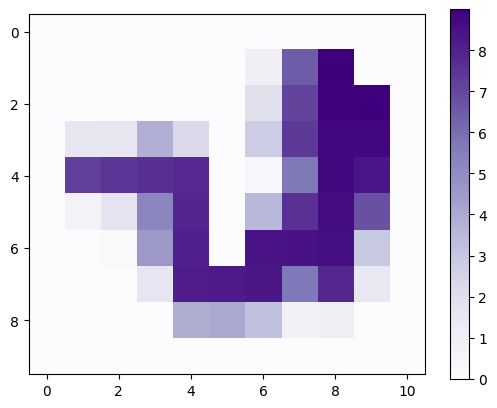

In [17]:
plt.imshow(q_table.max(axis=2), cmap='Purples')
plt.colorbar()

<Axes: >

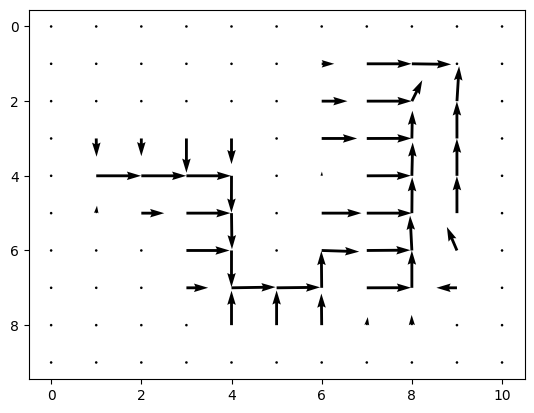

In [19]:
def policy_at_location(yx, q_table):
    """make a vector of expected direction in softmax policy stored in q_table"""
    inv_temp = 1
    qs = q_table[int(yx[0]), int(yx[1])]
    d4 = np.exp(inv_temp * (qs - qs.max())) # why do this?
    d4 /= max(0.1, d4.sum())
    return d4 @ Actions # dot product of probability and unit vectors
def visualize_policy(q_table):
    X, Y = np.meshgrid(np.linspace(0, 10, 11), np.linspace(0, 9, 10))
    pos = np.dstack((Y, X))
    uv = np.zeros_like(pos)
    for yx in sum(pos.tolist(), []):
        uv[int(yx[0]), int(yx[1])] = policy_at_location(yx, q_table)
        U = uv[:,:,0] # 10,10,1
        V = uv[:,:,1] # 10,10,1
    fixg, ax = plt.subplots()
    ax.invert_yaxis()
    ax.quiver(X, Y, V, U, angles='xy', scale_units='xy', scale=1)
    return ax
visualize_policy(q_table)